This is PART 1 of the code where I conducted several feature engineering and data processing steps to prepare the data for building a time-series model and for data analysis.
In Part 2, I will focus on building an ARIMA model for this time-series data.

In [211]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Dataset Information
The experimental testbed for occupancy estimation was deployed in a 6m x 4.6m room. The setup consisted of 7 sensor nodes and one edge node in a star configuration with the sensor nodes transmitting data to the edge every 30s using wireless transceivers. No HVAC systems were in use while the dataset was being collected.

Five different types of non-intrusive sensors were used in this experiment: temperature, light, sound, CO2 and digital passive infrared (PIR). The CO2, sound and PIR sensors needed manual calibration. For the CO2 sensor, zero-point calibration was manually done before its first use by keeping it in a clean environment for over 20 minutes and then pulling the calibration pin (HD pin) low for over 7s. The sound sensor is essentially a microphone with a variable-gain analog amplifier attached to it. Therefore, the output of this sensor is analog which is read by the microcontrollerâ€™s ADC in volts. The potentiometer tied to the gain of the amplifier was adjusted to ensure the highest sensitivity. The PIR sensor has two trimpots: one to tweak the sensitivity and the other to tweak the time for which the output stays high after detecting motion. Both of these were adjusted to the highest values. Sensor nodes S1-S4 consisted of temperature, light and sound sensors, S5 had a CO2 sensor and S6 and S7 had one PIR sensor each that were deployed on the ceiling ledges at an angle that maximized the sensorâ€™s field of view for motion detection.

The data was collected for a period of 4 days in a controlled manner with the occupancy in the room varying between 0 and 3 people. The ground truth of the occupancy count in the room was noted manually.

Date: YYYY/MM/DD

Time: HH:MM:SS

Temperature: In degree Celsius

Light: In Lux

Sound: In Volts (amplifier output read by ADC)

CO2: In PPM

CO2 Slope: Slope of CO2 values taken in a sliding window

PIR: Binary value conveying motion detection

Room_Occupancy_Count: Ground Truth

In [3]:
# Room Occupancy Estimation
df_occ = pd.read_csv('datasets/Occupancy_Estimation.csv')

In [4]:
df_occ.columns

Index(['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count'],
      dtype='object')

In [5]:
df_occ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

In [6]:
# Check the Date/Time data type
df_occ['Date'].dtype
df_occ['Time'].dtype

dtype('O')

In [7]:
df_occ['Date'].value_counts()

Date
2017/12/23    2779
2017/12/25    1716
2017/12/22    1462
2017/12/24    1064
2017/12/26    1063
2018/01/11    1048
2018/01/10     997
Name: count, dtype: int64

In [47]:
## The data covers the period from 2017-12-23 to 2018-01-11, 
# with no data available during the Christmas holiday (from 2017-12-27 to 2018-01-09).

In [8]:
# Convert Date and Time columns to time stamp
df_occ['Date'] = pd.to_datetime(df_occ['Date'], format='%Y/%m/%d')

# To show only the time portion
df_occ['Time'] = pd.to_datetime(df_occ['Time'], format='%H:%M:%S').dt.time

In [9]:
# Combine 'Date' and 'Time' into a single datetime column
df_occ['DateTime'] = pd.to_datetime(df_occ['Date'].astype(str) + ' ' + df_occ['Time'].astype(str))

In [10]:
#df_occ.insert(0,'DateTime', df_occ.pop('DateTime'))

In [11]:
# The focus will be on the signal from 'S1_Temp' sensor
df_signal = df_occ[['DateTime','S1_Temp']]

In [12]:
# Measure the time different between time stamps
df_signal['Time_diff'] = df_signal['DateTime'].diff()

C:\Users\Ken\AppData\Local\Temp\ipykernel_11628\55976990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['Time_diff'] = df_signal['DateTime'].diff()


In [13]:
df_signal['Time_diff'].value_counts()

Time_diff
0 days 00:00:31     6373
0 days 00:00:30     3614
0 days 00:01:01      131
0 days 00:02:34        2
0 days 00:01:02        2
0 days 00:25:32        1
0 days 00:01:32        1
0 days 00:03:35        1
0 days 00:03:04        1
1 days 00:00:52        1
15 days 06:15:47       1
Name: count, dtype: int64

In [30]:
# Grab the index of starting of the first gap
discontinuity_index = df_signal[df_signal['Time_diff'] == '1 days 00:00:52'].index.tolist()

In [162]:
# Identify the period up to the first gap (exclusive)
df_signal_1st_period = df_signal[:int(discontinuity_index[0])]

In [163]:
# Since the time stamp doesn't have consistent frequency, it needs to be recreated

In [164]:
# Identify the start and end times
start_time = df_signal_1st_period['DateTime'].iloc[0]
end_time = df_signal_1st_period['DateTime'].iloc[-1]

# Set DateTime as the index
df_signal_1st_period.set_index('DateTime', inplace=True)

In [165]:
# Create a new index
full_index = pd.date_range(start=start_time, end=end_time, freq='30S')

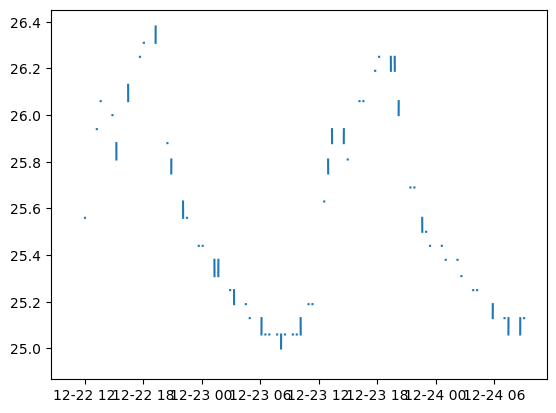

In [166]:
# Reindex the dataframe to the new index
df_signal_1st_period_reindexed = df_signal_1st_period.reindex(full_index)

plt.plot(df_signal_1st_period_reindexed['S1_Temp'])

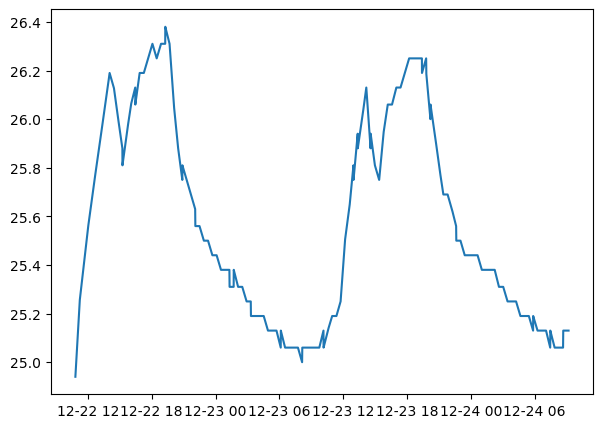

In [53]:
# Fill missing values in S1_Temp (resulted from creating new time stamps) using interpolation
df_signal_1st_completed = df_signal_1st_period_reindexed.drop(columns = 'Time_diff').interpolate(method='time')

fig = plt.figure(figsize = (7,5))
plt.plot(df_signal_1st_completed)

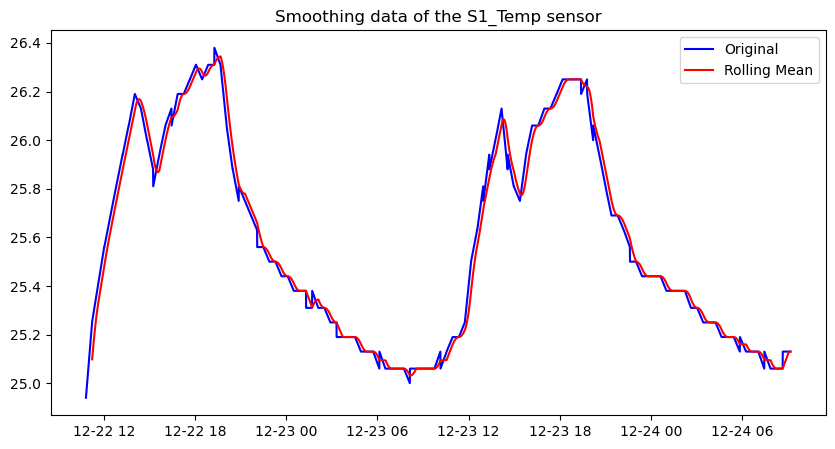

In [100]:
# Smooth the data using mean function

df_smooth = df_signal_1st_completed.rolling(50).mean()

fig = plt.figure(figsize = (10,5))
og = plt.plot(df_signal_1st_completed, color = 'blue', label = 'Original')
mean = plt.plot(df_smooth, color = 'red', label = 'Rolling Mean')

plt.legend(loc = 'best')
plt.title("Smoothing data of the S1_Temp sensor")
plt.show()

In [74]:
# Drop the na values of the smoothed dataframe
df_smooth.dropna(inplace= True)

In [121]:
# Find where is the min point at y-axis before the trend repeat itself
df_test = df_smooth.reset_index()

df_test['index'][df_test['S1_Temp'] == df_test['S1_Temp'].min()]

In [134]:
# Define the datetime strings
datetime_str1 = '2017-12-23 08:08:41' # represents the end of the seasonal period
datetime_str2 = '2017-12-22 11:14:11' # represents the start of the seasonal period

# Convert the strings to datetime objects
datetime_obj1 = datetime.strptime(datetime_str1, '%Y-%m-%d %H:%M:%S')
datetime_obj2 = datetime.strptime(datetime_str2, '%Y-%m-%d %H:%M:%S')

# Calculate the difference
time_difference = datetime_obj1 - datetime_obj2

# Convert the difference to seconds
difference_in_seconds = time_difference.total_seconds()

frequency = difference_in_seconds/30 # the result shows that the season repeats itself every 2509 point.

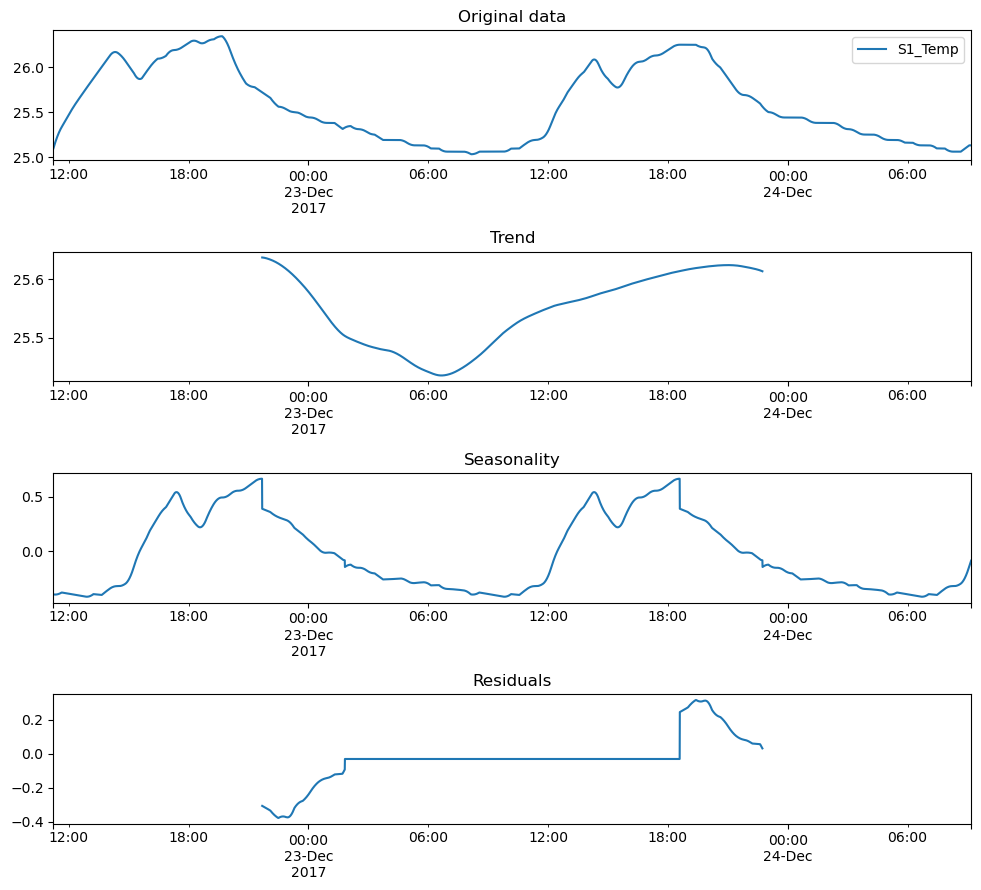

In [144]:
### Decomposition ###

# Decomposition based on stl - package: stldecompose
df_decomposed = seasonal_decompose(df_smooth, model='additive', period= int(frequency))

#df_decomposed.plot()
#plt.show()

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize = (10,9))
df_smooth.plot(ax = ax1)
df_decomposed.trend.plot(ax = ax2)
df_decomposed.seasonal.plot(ax = ax3)
df_decomposed.resid.plot(ax = ax4)
ax1.set_title('Original data')
ax2.set_title('Trend')
ax3.set_title('Seasonality')
ax4.set_title('Residuals')
plt.tight_layout()

In [ ]:
#### Cumsum ####

In [ ]:
# Reset the index
df_smooth.reset_index(names = 'DateTime', inplace = True)

# Calculate the cumulative
df_smooth['cumsum'] = df_smooth['S1_Temp'].cumsum()

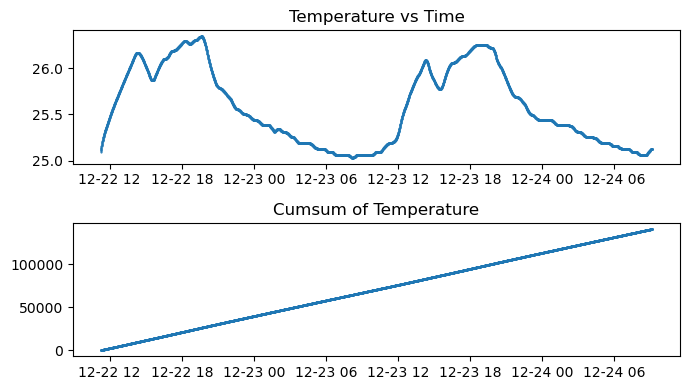

In [182]:
# Plot
plt.figure(figsize=(7,4))
plt.subplot(2,1,1)
plt.scatter(df_smooth['DateTime'], df_smooth['S1_Temp'], label='temp 1', marker='.', s = 1)
plt.title('Temperature vs Time')

plt.subplot(2,1,2)
plt.scatter(df_smooth['DateTime'], df_smooth['cumsum'], label='temp 1', marker='.', s = 1)
plt.title('Cumsum of Temperature')

plt.tight_layout()

The cumulative-sum plot shows a straight line, indicating constant increments between temperature values from the S1_Temp sensor. Although the temperature fluctuates, the rate of change is constant along the time series.

In [ ]:
### Stationary ###

In [199]:
# Stationary function

def stationarity_test(timeseries):
    print('Results of Dicky-Fuller Test:')
    df_test = adfuller(timeseries, autolag = 'AIC')
    df_output = pd.Series(df_test[0:4], 
                          index = ['Test statistic', 'p_value', 'Number of lags used', 'Number of observations used'])
    return(df_output)

In [200]:
stationarity_test(df_smooth['S1_Temp'])

Results of Dicky-Fuller Test:


Test statistic                   -1.806716
p_value                           0.377133
Number of lags used              16.000000
Number of observations used    5480.000000
dtype: float64

Since p-value (0.385291) < 0.05, time series data is non-stationary.

The data needs to be stationary for further analysis (e.g., for building ARIMA models).
Would try to remove trend (diffirences) or apply a transformation technique, sucah as applying log transformation to stabilise the variance.

In [204]:
# Apply seasonal differencing
df_smooth['Temp_diff'] = df_smooth['S1_Temp'].diff()
df_smooth.dropna(inplace=True)

In [205]:
stationarity_test(df_smooth['Temp_diff'])

Results of Dicky-Fuller Test:


Test statistic                   -5.390666
p_value                           0.000004
Number of lags used              16.000000
Number of observations used    5479.000000
dtype: float64

p-value is less than 0.05, indicating the series is stationary

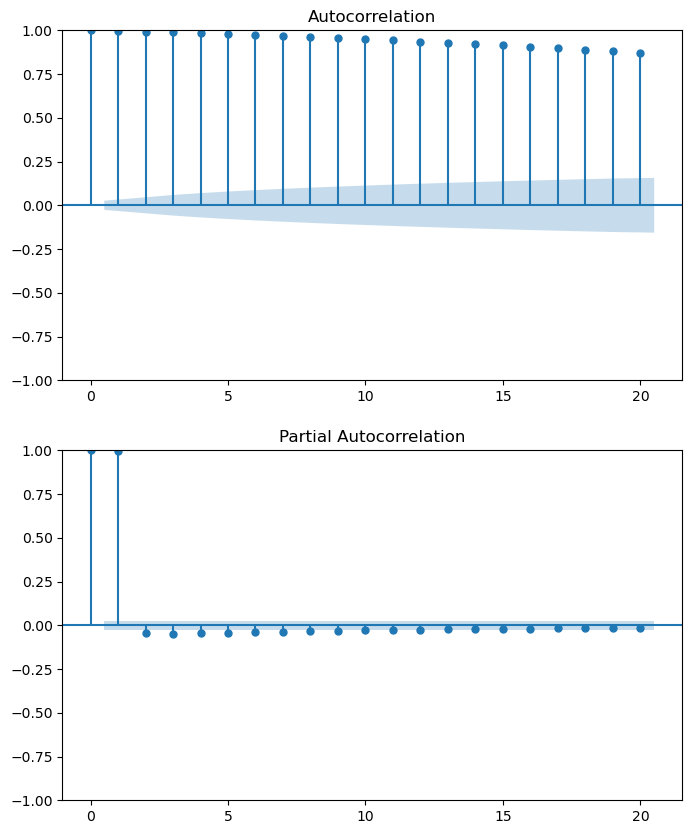

In [210]:
### Autocorrelation ###

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (8,10))
plot_acf(df_smooth['Temp_diff'], lags = 20, ax = ax1)
plot_pacf(df_smooth['Temp_diff'], lags = 20, ax = ax2)

plt.show()